<h1>Batik Nusantara - Content Based Imaged Retrieval (CBIR)</h1>
<p>Author: HendryHB</p>

<h3>Introduction</h3>
<p>Content-Based Image Retrieval (CBIR) is a technology that enables the automatic indexing and retrieval of images from a large database by analyzing the visual content of the images themselves rather than relying on metadata or textual descriptions. The concept of CBIR has been developed and refined over several decades, with contributions from numerous researchers and institutions.

The idea of CBIR can be traced back to the early 1990s, by [1] QVE (Query by Visual Example), querying image databases using visual examples rather than relying solely on text-based queries. It was a significant contribution to the field and laid the groundwork for many subsequent developments in CBIR.</p>

<h3>Conceptual</h3>
<p>CBIR is a technique used for retrieving images from large databases based on their visual content rather than relying solely on metadata or textual descriptions. The primary goal of CBIR is to enable efficient and effective image searches by analyzing the intrinsic features of the images themselves, such as color, texture, shape, and spatial layout.</p>

<h5>Components of CBIR:</h5>
<ol>
    <li>Feature Extraction: This involves extracting relevant visual features from the images. These features can include color, texture, shape, spatial layout.
    </li>
    <li>Feature Representation: The extracted features are represented in a way that facilitates comparison and retrieval. This often involves creating feature vectors that encapsulate the visual characteristics of each image.</li>
    <li>Indexing: The feature vectors are indexed to allow for efficient searching. Indexing techniques like KD-trees, R-trees, or hashing are commonly used to speed up the retrieval process.</li>
    <li>Query Processing: Users can submit a query in the form of an example image, a sketch, or by specifying visual attributes. The system then extracts features from the query image in the same way as for the database images.</li>
    <li>Similarity Measurement: The system measures the similarity between the query image and database images using distance metrics such as Euclidean distance, cosine similarity, or histogram intersection.</li>
    <li>Retrieval and Ranking: Images from the database are retrieved and ranked based on their similarity scores to the query image. The most similar images are presented to the user as the search results.</li>
</ol>

<h3>Bibliography</h3>
<p>
[1] K. Hirata and T. Kato, “Query by Visual Example - Content based Image Retrieval,” in Proceedings of the 3rd International Conference on Extending Database Technology: Advances in Database Technology, in EDBT ’92. Berlin, Heidelberg: Springer-Verlag, Mar. 1992, pp. 56–71.</p>

In [1]:
# from google.colab import drive  # for google colab
# import zipfile  # for google colab
import sys
import numpy as np
import os
from PIL import Image
import pandas as pd
import tensorflow as tf
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout,  BatchNormalization, Activation, Flatten
from tensorflow.keras import layers, Model

from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(42)

In [ ]:
drive.mount('/content/drive')  # for google colab

In [4]:
with zipfile.ZipFile("/content/drive/MyDrive/raw_batik_v2.1.zip") as zip_ref:  # for colab
  zip_ref.extractall("./")

# Constants

In [2]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_CHANNELS = 3
BATCH_SIZE = 32

# Data Gathering

In [3]:
# Directory containing the data - fetching dataset from google drive
DATA_DIR = "/content/raw_batik_v2.1.zip"

common_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    rescale=1./255 
)

# Set up data generators for training, validation, and testing
train_generator = common_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # Set the target image size
    batch_size=BATCH_SIZE,
    color_mode='rgb', # Set color mode to RGB,
    shuffle=False, 
    class_mode='categorical'  # For multi classes
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=os.path.join(DATA_DIR, "test"),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='rgb', # Set color mode to RGB
    shuffle=False,
    class_mode='categorical'
)

Found 640 images belonging to 20 classes.
Found 160 images belonging to 20 classes.


# Data Exploration

## Train Dataset

#### `.n` is an attribute to the total count of images found and `.num_classes` is the number of subdirectories found (classes)

In [4]:
x_train_images = train_generator.n
y_train_classes = train_generator.num_classes
print(f"Number of images: {train_generator.n}, Number of classes:{train_generator.num_classes}")

Number of images: 640, Number of classes:20


In [5]:
x_train_all = []
y_train_all = []

# Looping, check: // BATCH_SIZE or + 1
for _ in range(x_train_images // BATCH_SIZE ):
    x_batch, y_batch = next(train_generator)
    x_train_all.append(x_batch)
    y_train_all.append(y_batch)

# Concatenate
x_train = np.concatenate(x_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)

# Display the shapes of x and y_train
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (640, 224, 224, 3)
y_train shape: (640, 20)


In [6]:
# Get class indices and create a reverse mapping
x_train_class_indices = train_generator.class_indices
y_train_index_to_class = {v: k for k, v in x_train_class_indices.items()}

## Test Dataset

In [7]:
x_test_images = test_generator.n
y_test_classes = test_generator.num_classes
print(f"Number of images: {test_generator.n}, Number of classes:{test_generator.num_classes}")

Number of images: 160, Number of classes:20


In [8]:
x_test_all = []
y_test_all = []

# Looping, check: // BATCH_SIZE or + 1
for _ in range(x_test_images // BATCH_SIZE):
    x_test_batch, y_test_batch = next(test_generator)
    x_test_all.append(x_test_batch)
    y_test_all.append(y_test_batch)

# Concatenate
x_test = np.concatenate(x_test_all, axis=0)
y_test = np.concatenate(y_test_all, axis=0)

# Display the shapes of x and y_train
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (160, 224, 224, 3)
y_test shape: (160, 20)


## Self-Defined CNN

In [12]:
# Define the custom CNN model
def create_custom_cnn():
    input_layer = tf.keras.layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, COLOR_CHANNELS))
    
    # block 1
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    norm1 = tf.keras.layers.BatchNormalization(axis=-1)(pool1)
    drop1 = tf.keras.layers.Dropout(rate=0.2)(norm1)
    
    # block 2
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(drop1)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    norm2 = tf.keras.layers.BatchNormalization(axis=-1)(pool2)
    drop2 = tf.keras.layers.Dropout(rate=0.2)(norm2)
    
    # block 3
    conv3 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(drop2)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    norm3 = tf.keras.layers.BatchNormalization(axis=-1)(pool3)
    drop3 = tf.keras.layers.Dropout(rate=0.2)(norm3)
    
    # block 4
    conv4 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(drop3)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    norm4 = tf.keras.layers.BatchNormalization(axis=-1)(pool4)
    drop4 = tf.keras.layers.Dropout(rate=0.2)(norm4)
    
    # block 5
    conv5 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(drop4)
    pool5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv5)
    norm5 = tf.keras.layers.BatchNormalization(axis=-1)(pool5)
    drop5 = tf.keras.layers.Dropout(rate=0.2)(norm5)
    
    flat = tf.keras.layers.Flatten()(drop5)  # Flatten the matrix to get it ready for dense layers.
    
    # Dense Layers
    hidden1 = tf.keras.layers.Dense(64, activation='relu')(flat)
    norm6 = tf.keras.layers.BatchNormalization(axis=-1)(hidden1)
    drop6 = tf.keras.layers.Dropout(rate=0.2)(norm6)
    
    output_layer = tf.keras.layers.Dense(20, activation='softmax')(drop6)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [13]:
# Create the model
custom_cnn_model = create_custom_cnn()

# Compile

In [14]:
custom_cnn_model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

<h1>Extracting Features Using the Custom CNN Model</h1>
<p>
    <strong><code>feature_extractor</code></strong> is a TensorFlow Keras model created from the original custom_cnn_model and is to use the convolutional and pooling layers of the custom CNN (in this case it uses self-defined CNN, feel free to use other pretrained archictecure such as VGG, ResNet and others) to extract high-level features from images, rather than to classify them.
    
<h3>Code explanation</h3>   
     <ul> 
        <li>Defines a feature extractor model by truncating the custom CNN model before the final dense layers.<br>It includes all the layers up to, but excluding, the final dense layers (the last four layers of the original model). This is often done <strong>to use the CNN (and any other pretrained architectures) as a feature extractor</strong> <em><strong>rather than a classifier</em></strong> (the dense layers that are specific to the classification task).</li>   
        <li><code>extract_features</code> is a function that takes image data and a model <code>(img_data, model)</code>, then uses the model to predict (extract) features from the image data. <code>extract_features</code> is to obtain the high-level feature representations of images using the feature_extractor model.</li>
        <li><code>train_features</code> extracts features from all images in the training dataset <code>(x_train)</code> using the <code>feature_extractor</code> model and its purpose is to create a feature representation for each training image, which can later be used for tasks such as similarity comparison or retrieval.</li>
    </ul>
</p>

In [24]:
# Extract features using the custom CNN model
feature_extractor = tf.keras.Model(inputs=custom_cnn_model.input, outputs=custom_cnn_model.layers[-4].output)

In [25]:
# Function to extract features using the custom CNN
def extract_features(img_data, model):
    features = model.predict(img_data)
    
    return features

In [26]:
# Extract features for train dataset
train_features = extract_features(x_train, feature_extractor)
print("Train features shape:", train_features.shape)

20/20 [==============================] - 67s 3s/step
Train features shape: (640, 64)


<h3>Code explanation</h3>
<ul>
    <li>Selects the first image from the test dataset <code>x_test</code> which aims to use this image as a query to find similar images in the training dataset.</li>
    <li><code>extract_features</code> function is called with the expanded query image and the feature extractor model.
This function returns the feature representation of the query image produced by the feature extractor model.</li>
    <li><code>np.expand_dims(query_image, axis=0)</code> adds an extra dimension to the query_image to make it compatible with the <code>feature_extractor</code> model, this is to ensure the query image has the correct shape for the model to process. This changes the shape from <code>(IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)</code> to <code>(1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)</code>, where <code>1</code> represents the batch size.</li>
    <li><code>feature_extractor</code> to extract features from the query image and flattens the resulting feature map which aims to obtain a one-dimensional feature vector for the query image, which can be used to compare with features of training images.</li>
    <li><code>flatten()</code> converts the multi-dimensional feature representation into a one-dimensional array. This is often necessary for certain similarity computations, such as <strong>cosine similarity</strong>.</li>
</ul>

In [27]:
# Example query image (first image from the test set)
query_image = x_test[0]
query_features = extract_features(np.expand_dims(query_image, axis=0), feature_extractor).flatten()

1/1 [==============================] - 1s 857ms/step


<h1>Computing Similarity Between Query Image and Train Dataset Images</h1>
<p>Computes the cosine similarity between the query image features and the features of all training images with steps:
    <ol>
        <li>Compute Similarity</li>
        <li>Extract Similarity Scores</li>
    </ol>
</p>


In [28]:
# Compute similarity between query image and train dataset images
similarities = cosine_similarity([query_features], train_features)
similarity_scores = similarities[0]
# print(similarity_scores)

<h1>Displaying Top N Similar Images</h1>
<p>At this stage:
<ul>
    <li>Sets the number of top results to display (<code>N</code>).</li>
    <li>Sorts the similarity scores and retrieves the indices of the top N similar images.</li>
    <li>Maps filenames to their true class labels.</li>
    <li>Prints the filenames, class labels, and similarity scores of the top N similar images.</li>
</ul>
</p>

In [29]:
# Number of top results to display
N = 5  # Change this to the number of top results as needed 

# Get indices of top N similar images
top_indices = similarity_scores.argsort()[-N:][::-1]

# Create a mapping from filenames to true labels using the directory structure
filename_to_label = {filename: y_train_index_to_class[train_generator.classes[idx]] for idx, filename in enumerate(train_generator.filenames)}


In [32]:
# Print the headings
print(f"{'Filename':<50} {'Class':<30} {'Similarity Score':<20}")

# Display top N similar images with filenames, class names, and similarity scores
for idx in top_indices:
    filename = train_generator.filenames[idx]
    class_label = filename_to_label[filename]
    print(f"{filename:<50} {class_label:<30} {similarity_scores[idx]:<20.4f}")

Filename                                           Class                          Similarity Score    
Lampung_Gajah/004.jpg                              Lampung_Gajah                  0.9896              
Papua_Asmat/0022.jpg                               Papua_Asmat                    0.9882              
NTB_Lumbung/0030.jpg                               NTB_Lumbung                    0.9860              
Lampung_Gajah/0022.jpg                             Lampung_Gajah                  0.9859              
SumateraBarat_Rumah_Minang/0025.jpg                SumateraBarat_Rumah_Minang     0.9856              


<h1>Plotting the Images in a Grid</h1>
<p>Defining a <code>plot_similar_images</code>function to plot images in grid in which:
    <ul>
        <li>Determines the number of rows and columns based on the number of images and sets up the plot.</li>
        <li>Plots each image along with its class label and filename.</li>
        <li>Calls the function to display the top N similar images in a grid.</li>
    </ul>
</p>

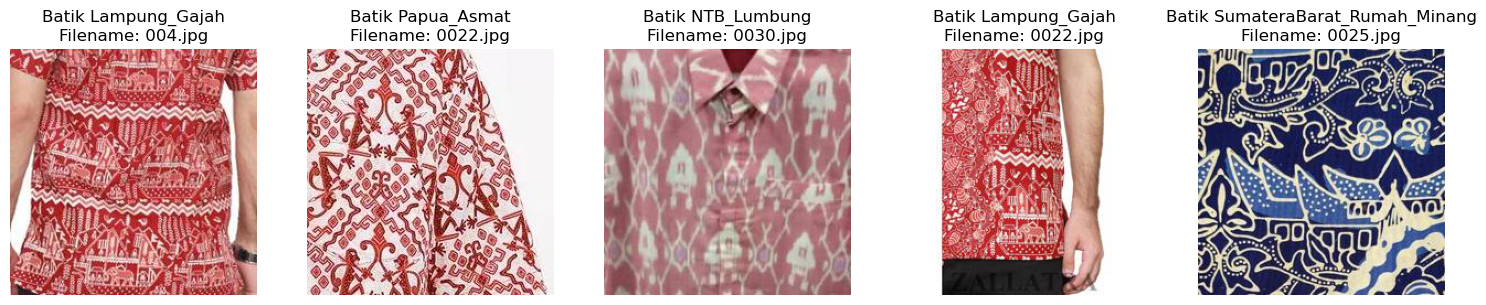

In [34]:
# Function to plot images
def plot_similar_images(indices, filenames, class_labels, data_dir):  
    num_images = len(indices)
    num_cols = 5
    num_rows = np.ceil(num_images / num_cols).astype(int)
    
    plt.figure(figsize=(15, num_rows * 3))  # Adjust the height as needed
    
    for i, idx in enumerate(indices):
        filename = filenames[idx]
        class_label = class_labels[filename]
        # similarity_score = similarity_scores[idx]
        
        img_path = os.path.join(data_dir, "train", filename)
        img = image.load_img(img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
        
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"Batik {class_label}\nFilename: {os.path.basename(filename)}")  
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_similar_images(top_indices, train_generator.filenames, filename_to_label, DATA_DIR)  

<h1>Summary</h1>

<p>Content-Based Image Retrieval (CBIR) represents a significant advancement in image retrieval technology, offering more intuitive and effective ways to search and interact with visual data.</p>